In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import DataFrame 
import nltk

from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from scipy.spatial.distance import cosine
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import re
import string
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import mean_squared_error

In [9]:
df = pd.read_json('Cell_Phones.json',lines=True)
df[['HelpfulnessNumerator','HelpfulnessDenominator']] = pd.DataFrame(df.helpful.values.tolist(), index = df.index)

In [10]:
print(df.columns)
print(df.shape)

Index(['asin', 'helpful', 'overall', 'reviewText', 'reviewTime', 'reviewerID',
       'reviewerName', 'summary', 'unixReviewTime', 'HelpfulnessNumerator',
       'HelpfulnessDenominator'],
      dtype='object')
(194439, 11)


In [11]:
count = df.groupby("asin", as_index=False).count()
mean = df.groupby("asin", as_index=False).mean()

dfMerged = pd.merge(df, count, how='right', on=['asin'])
dfMerged

,asin,helpful_x,overall_x,reviewText_x,reviewTime_x,reviewerID_x,reviewerName_x,summary_x,unixReviewTime_x,HelpfulnessNumerator_x,...,helpful_y,overall_y,reviewText_y,reviewTime_y,reviewerID_y,reviewerName_y,summary_y,unixReviewTime_y,HelpfulnessNumerator_y,HelpfulnessDenominator_y
0,120401325X,"[0, 0]",4,They look good and stick good! I just don't li...,"05 21, 2014",A30TL5EWN6DFXT,christina,Looks Good,1400630400,0,...,7,7,7,7,7,7,7,7,7,7
1,120401325X,"[0, 0]",5,These stickers work like the review says they ...,"01 14, 2014",ASY55RVNIL0UD,emily l.,Really great product.,1389657600,0,...,7,7,7,7,7,7,7,7,7,7
2,120401325X,"[0, 0]",5,These are awesome and make my phone look so st...,"06 26, 2014",A2TMXE2AFO7ONB,Erica,LOVE LOVE LOVE,1403740800,0,...,7,7,7,7,7,7,7,7,7,7
3,120401325X,"[4, 4]",4,Item arrived in great time and was in perfect ...,"10 21, 2013",AWJ0WZQYMYFQ4,JM,Cute!,1382313600,4,...,7,7,7,7,7,7,7,7,7,7
4,120401325X,"[2, 3]",5,"awesome! stays on, and looks great. can be use...","02 3, 2013",ATX7CZYFXI1KW,patrice m rogoza,leopard home button sticker for iphone 4s,1359849600,2,...,7,7,7,7,7,7,7,7,7,7
5,120401325X,"[1, 2]",3,These make using the home button easy. My daug...,"10 12, 2013",APX47D16JOP7H,RLH,Cute,1381536000,1,...,7,7,7,7,7,7,7,7,7,7
6,120401325X,"[0, 0]",5,Came just as described.. It doesn't come unstu...,"08 22, 2013",A1JVVYYO7G56DS,Tyler Evans,best thing ever..,1377129600,0,...,7,7,7,7,7,7,7,7,7,7
7,3998899561,"[1, 2]",1,it worked for the first week then it only char...,"11 21, 2013",A6FGO4TBZ3QFZ,Abdullah Albyati,not a good Idea,1384992000,1,...,10,10,10,10,10,10,10,10,10,10
8,3998899561,"[2, 3]",5,"Good case, solid build. Protects phone all aro...","09 25, 2013",A2JWEDW5FSVB0F,Adam,Solid Case,1380067200,2,...,10,10,10,10,10,10,10,10,10,10
9,3998899561,"[1, 1]",5,This is a fantastic case. Very stylish and pro...,"04 3, 2014",A8AJS1DW7L3JJ,Agata Majchrzak,Perfect Case,1396483200,1,...,10,10,10,10,10,10,10,10,10,10


In [12]:
#rename column
dfMerged["totalReviewers"] = dfMerged["reviewerID_y"]
dfMerged["overallScore"] = dfMerged["overall_x"]
dfMerged["summaryReview"] = dfMerged["summary_x"]

dfNew = dfMerged[['asin','summaryReview','overallScore',"totalReviewers"]]

In [13]:
dfMerged = dfMerged.sort_values(by='totalReviewers', ascending=False)
dfCount = dfMerged[dfMerged.totalReviewers >= 100]
dfCount

,asin,helpful_x,overall_x,reviewText_x,reviewTime_x,reviewerID_x,reviewerName_x,summary_x,unixReviewTime_x,HelpfulnessNumerator_x,...,reviewTime_y,reviewerID_y,reviewerName_y,summary_y,unixReviewTime_y,HelpfulnessNumerator_y,HelpfulnessDenominator_y,totalReviewers,overallScore,summaryReview
60401,B005SUHPO6,"[0, 1]",5,This product its good to protect the fragile i...,"07 13, 2013",AZ1NSCXQKRGUH,Sam,Really Good,1373673600,0,...,837,837,836,837,837,837,837,837,5,Really Good
60498,B005SUHPO6,"[0, 0]",5,this a very good case and i recomend it to all...,"02 3, 2013",A2N6XPEZYSGAU0,tractorman6070,case,1359849600,0,...,837,837,836,837,837,837,837,837,5,case
60526,B005SUHPO6,"[0, 0]",5,"The color is great and as usual, an Otter Box ...","03 15, 2014",A30J79TFWG8XMY,Walawa05,Love it,1394841600,0,...,837,837,836,837,837,837,837,837,5,Love it
60527,B005SUHPO6,"[0, 0]",5,I bought an Otterbox Defender case for my iPho...,"01 23, 2013",A1EUUXDQPWPLP4,Wall St 2 Broadway,"Great case, great company",1358899200,0,...,837,837,836,837,837,837,837,837,5,"Great case, great company"
60528,B005SUHPO6,"[0, 0]",4,I got this for my son's iPhone 4s. I thought i...,"12 16, 2013",A2CPAOK621BE07,W. Brooks,"Great protection, but bulky as hell",1387152000,0,...,837,837,836,837,837,837,837,837,4,"Great protection, but bulky as hell"
60529,B005SUHPO6,"[0, 0]",5,absolutely LOVE otterboxes! dropped my phone s...,"10 7, 2013",A1A6LY0I5OE33O,Wendi,yay for otterboxes!,1381104000,0,...,837,837,836,837,837,837,837,837,5,yay for otterboxes!
60530,B005SUHPO6,"[0, 0]",5,Product is just right. The only way it could b...,"12 2, 2012",ANCI96JKBOGS,"Wendy M. Evett ""nursewee""",just right.,1354406400,0,...,837,837,836,837,837,837,837,837,5,just right.
60531,B005SUHPO6,"[0, 0]",5,It was a case that was the best of otter boxes...,"02 5, 2013",A2E12XDYLB01A0,Whatup,Recommend,1360022400,0,...,837,837,836,837,837,837,837,837,5,Recommend
60532,B005SUHPO6,"[0, 0]",5,Love this!! a little hard to put on phone but...,"02 5, 2013",A8PJGILZJE4B1,wick,otterbox,1360022400,0,...,837,837,836,837,837,837,837,837,5,otterbox
60533,B005SUHPO6,"[0, 0]",5,I wanted a case that provided above average pr...,"04 15, 2013",A3NSTC73P8F9P3,"William D. Pierce ""The State of Jefferson""",Well designed ...,1365984000,0,...,837,837,836,837,837,837,837,837,5,Well designed ...


In [14]:
dfProductReview = df.groupby("asin", as_index=False).mean()
ProductReviewSummary = dfCount.groupby("asin")["summaryReview"].apply(list)
ProductReviewSummary = pd.DataFrame(ProductReviewSummary)
ProductReviewSummary.to_csv("ProductReviewSummary.csv")

In [15]:
dfProductReview

,asin,overall,unixReviewTime,HelpfulnessNumerator,HelpfulnessDenominator
0,120401325X,4.428571,1.384980e+09,1.000000,1.285714
1,3998899561,4.600000,1.387835e+09,2.400000,3.200000
2,6073894996,3.891892,1.376779e+09,0.216216,0.324324
3,7532385086,4.444444,1.344067e+09,0.333333,0.333333
4,7887421268,4.000000,1.354865e+09,0.153846,0.153846
5,8199406933,4.800000,1.360506e+09,0.000000,0.000000
6,8288853439,4.300000,1.386003e+09,0.500000,0.500000
7,8288855504,4.666667,1.317053e+09,0.166667,0.166667
8,8288862993,3.880000,1.370173e+09,0.000000,0.000000
9,8288878881,3.291667,1.377000e+09,0.083333,0.125000


In [16]:
df3 = pd.read_csv("ProductReviewSummary.csv")
df3 = pd.merge(df3, dfProductReview, on="asin", how='inner')

In [17]:
df3 = df3[['asin','summaryReview','overall']]

In [18]:
regEx = re.compile('[^a-z]+')
def cleanReviews(reviewText):
    reviewText = reviewText.lower()
    reviewText = regEx.sub(' ', reviewText).strip()
    return reviewText

In [19]:
df3["summaryClean"] = df3["summaryReview"].apply(cleanReviews)
df3 = df3.drop_duplicates(['overall'], keep='last')
df3 = df3.reset_index()

In [20]:
reviews = df3["summaryClean"] 
countVector = CountVectorizer(max_features = 300, stop_words='english') 
transformedReviews = countVector.fit_transform(reviews) 

dfReviews = DataFrame(transformedReviews.A, columns=countVector.get_feature_names())
dfReviews = dfReviews.astype(int)

In [21]:
dfReviews.to_csv("dfReviews.csv")

In [22]:
X = np.array(dfReviews)
 # create train and test
tpercent = 0.9
tsize = int(np.floor(tpercent * len(dfReviews)))
dfReviews_train = X[:tsize]
dfReviews_test = X[tsize:]
#len of train and test
lentrain = len(dfReviews_train)
lentest = len(dfReviews_test)

In [23]:
print(lentrain)
print(lentest)

187
21


In [24]:
neighbor = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(dfReviews_train)

# Let's find the k-neighbors of each point in object X. To do that we call the kneighbors() function on object X.
distances, indices = neighbor.kneighbors(dfReviews_train)

In [25]:
for i in range(lentest):
    a = neighbor.kneighbors([dfReviews_test[i]])
    related_product_list = a[1]

    first_related_product = [item[0] for item in related_product_list]
    first_related_product = str(first_related_product).strip('[]')
    first_related_product = int(first_related_product)
    second_related_product = [item[1] for item in related_product_list]
    second_related_product = str(second_related_product).strip('[]')
    second_related_product = int(second_related_product)
    
    print ("Based on product reviews, for ", df3["asin"][lentrain + i] ," average rating is ",df3["overall"][lentrain + i])
    print ("The first similar product is ", df3["asin"][first_related_product] ," average rating is ",df3["overall"][first_related_product])
    print ("The second similar product is ", df3["asin"][second_related_product] ," average rating is ",df3["overall"][second_related_product])
    print ("-----------------------------------------------------------")

Based on product reviews, for  B00DDLYCUW  average rating is  4.515923566878981
The first similar product is  B00B8MMZY8  average rating is  4.175438596491228
The second similar product is  B009HD44US  average rating is  4.655737704918033
-----------------------------------------------------------
Based on product reviews, for  B00DIOALPE  average rating is  3.7548387096774194
The first similar product is  B00428N9OK  average rating is  3.5934959349593494
The second similar product is  B004E10KFG  average rating is  4.0625
-----------------------------------------------------------
Based on product reviews, for  B00DMKGPP4  average rating is  4.648044692737431
The first similar product is  B0093IHVJI  average rating is  4.171673819742489
The second similar product is  B00DCIZJ5S  average rating is  4.311224489795919
-----------------------------------------------------------
Based on product reviews, for  B00DRJTY44  average rating is  4.183206106870229
The first similar product is  B0

In [27]:
df5_train_target = df3["overall"][:lentrain]
df5_test_target = df3["overall"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_test_target = df5_test_target.astype(int)

n_neighbors = 3
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(dfReviews_train, df5_train_target)
knnpreds_test = knnclf.predict(dfReviews_test)

print(classification_report(df5_test_target, knnpreds_test))

              precision    recall  f1-score   support

           3       0.50      0.33      0.40         3
           4       0.89      0.94      0.92        18

   micro avg       0.86      0.86      0.86        21
   macro avg       0.70      0.64      0.66        21
weighted avg       0.84      0.86      0.84        21



In [28]:
print (accuracy_score(df5_test_target, knnpreds_test))

0.8571428571428571


In [29]:
print(mean_squared_error(df5_test_target, knnpreds_test))

0.14285714285714285


In [30]:
cluster = df.groupby("overall")["summary"].apply(list)
cluster = pd.DataFrame(cluster)
cluster.to_csv("cluster.csv")
cluster1 = pd.read_csv("cluster.csv")
cluster1["summaryClean"] = cluster1["summary"].apply(cleanReviews)

In [31]:
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=500,
        max_font_size=30, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

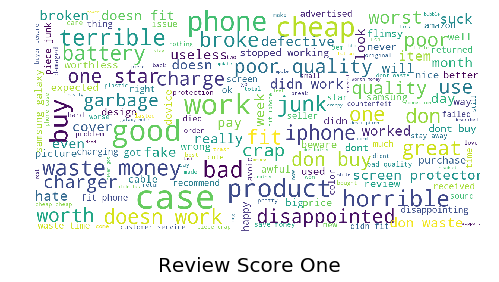

In [32]:
show_wordcloud(cluster1["summaryClean"][0], title = "Review Score One")

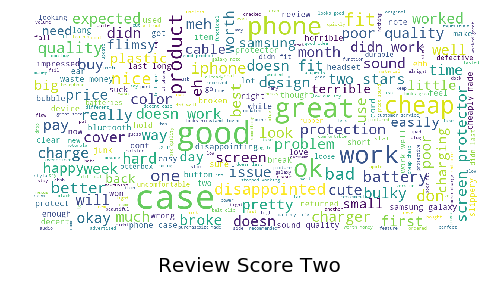

In [33]:
show_wordcloud(cluster1["summaryClean"][1] , title = "Review Score Two")

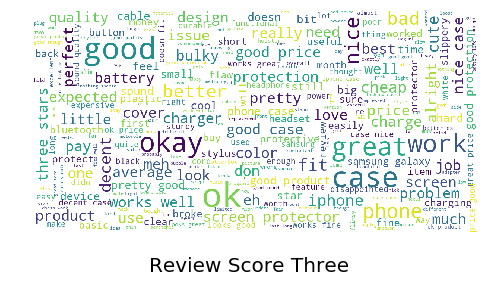

In [34]:
show_wordcloud(cluster1["summaryClean"][2], title = "Review Score Three")

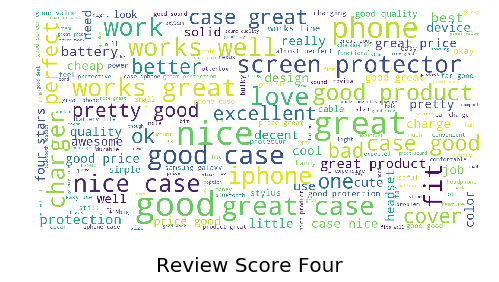

In [35]:
show_wordcloud(cluster1["summaryClean"][3], title = "Review Score Four")

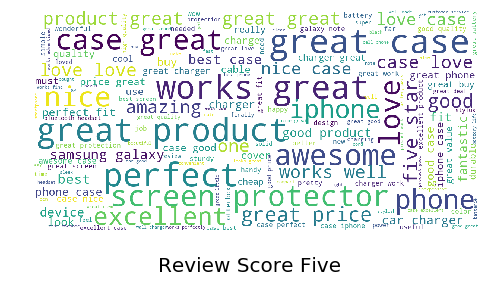

In [36]:
show_wordcloud(cluster1["summaryClean"][4], title = "Review Score Five")